In [1]:
import matplotlib.pyplot as plt

# for regression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from numpy.polynomial.polynomial import polyval, polyder

# for GPR
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, Matern, ConstantKernel
from sklearn.gaussian_process import GaussianProcessRegressor

from scipy.stats import norm

import random
#import time

from sklearn import mixture
from GMM_Conditional import *

import Heston_g as hest        # for Heston Pricing
import scipy.stats as si     # for European Option Pricing (cdf)

In [2]:
def heston_qestep(Xt,Vt,sigma,vLong,kappa,rho,deltat,gamma1,gamma2,psiC):    
    #QE discretization Agorithm for the Return Process {Xt+1}, yield one step ahead return conditional on Vt and Xt
    # new variance
        k1 = np.exp(-kappa*deltat)
        k2 = sigma**2 * k1 * (1-k1)/kappa
        k3 = np.exp(kappa*deltat)*0.5*k2*(1-k1)*vLong
        
        m = vLong +(Vt - vLong) * k1
        s2 = Vt * k2 + k3
        psi = s2/m**2
        if psi <= psiC:
            b2 = 2/psi-1 + (2/psi*(2/psi-1))**0.5 
            a = m/(1+b2)
            Zv = norm.ppf(random.random())
            Vnew = a*(Zv + b2**0.5)**2    #Non central Chi square variable aproximate sufficiently big value of Vt
        elif psi > psiC:
            p = (psi-1)/(psi+1)
            #beta = 2/ (m+m*psi)           #Function of Delta Dirac variable for sufficiently small value of Vt
            beta = (1-p)/m
            Uv = random.random()
            if Uv <=p:
                Vnew=0
            elif Uv> p:
                Vnew = np.log((1-p)/(1-Uv)) / beta
        
        # variables for the predictor-corrector step
        K0 = -(rho*kappa*vLong)*deltat/sigma 
        K1 = gamma1*deltat*(-0.5+(kappa*rho/sigma))-(rho/sigma)
        K2 = gamma2*deltat*(-0.5+(kappa*rho/sigma))+(rho/sigma)
        K3 = gamma1*deltat*(1-rho**2)
        K4 = gamma2*deltat*(1-rho**2)
        Zv = norm.ppf(random.random())              # Gaussian N(0,1)
        # predictor-corrector step
        Xnew = Xt + (r- q) * deltat + K0 + K1 * Vt + K2 * Vnew + ((K3 * Vt + K4 * Vnew)**0.5) * Zv
        return [Xnew,Vnew]


def heston_qe(S,v0,sigma,vLong,kappa,rho,T,NSim,NT):
    gamma1 = 0.5 #averaging factors for the discretivazion of Xt
    gamma2 = 0.5 #averaging factors for the discretivazion of Xt
    psiC = 1.5   #Threshold for the initiation of the two aproximate distribution of V(t+1 | Vt)
        
    Nt = NT+1    # index 0 keeps the current values for S and V   
    deltat = T/NT
        
    # stores the paths
    pathS = np.zeros([NSim,Nt])
    pathV = np.zeros([NSim,Nt])
    pathS[:,0] = S
    pathV[:,0] = v0

    for i in range(NSim):
        Snew = np.log(S*np.exp(-q*T))
        Vnew = v0
        #print(Nt)
        for j in range(NT): 
            new = heston_qestep(Snew,Vnew,sigma,vLong,kappa,rho,deltat,gamma1,gamma2,psiC) 
               
            Snew = new[0] 
            Vnew = new[1]

            pathS[i,j+1] = np.exp(Snew)
            pathV[i,j+1] = Vnew
    
    return pathS, pathV

In [3]:
def PriceEuroVanilla(S, K, T, r, sigma, option = 'call'):
    
    #S: spot price
    #K: strike price
    #T: time to maturity
    #r: interest rate
    #sigma: volatility of underlying asset
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
       
    if option == 'call':
        Nd1 = si.norm.cdf(d1, 0.0, 1.0)
        Nd2 = si.norm.cdf(d2, 0.0, 1.0)
        result = (S * Nd1 - K * np.exp(-r * T) * Nd2)
        delta = Nd1
        
    if option == 'put':
        result = (K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0) - S * si.norm.cdf(-d1, 0.0, 1.0))
        delta = Nd2

    vega = S * si.norm.pdf(d1, 0.0, 1.0) * np.sqrt(T)
    
    return result, delta, vega

In [4]:
# Heston parameters
S0 = 100.0        # spot asset
Nsim = 10000      # number of simulations

K = 95            # strike price
r = 0.01          # rate
q = 0.0           # continuous dividend yield
v0 = 0.3**2       # spot variance
vLong = 0.32**2   # long term variance
kappa = 0.2       # reversion rate for variance
sigma = 0.3       # volatility of variance
rho = -0.5        # correlation of BM for asset and variance

feller = 2 * kappa * vLong/sigma**2

time_grid = np.array([0.0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1.0])

idx_T = -1            # index on time grid T
idx_t = -2            # index on time grid t, -2 corresponds to .9, -6 to .5
T = time_grid[idx_T]  # get the time for T from grid
t = time_grid[idx_t]  # get the time for t from grid
df = np.exp(-r*(T-t)) # discount factor 

Nt = 10               #

# run Heston simulation
np.random.seed(0)                                       # random seed
S, V = heston_qe(S0,v0,sigma,vLong,kappa,rho,T,Nsim,Nt) # simulate and store S and V

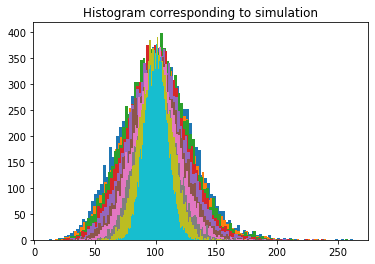

262.4351273621721 11.733790132353187 0.4551111111111112


In [5]:
# plot histograms for the grid
plt.figure()
nbins = 100                   # number of bins used
ir = len(time_grid)
for j in range(0,ir-1):
    plt.hist(S[:,-(j+1)],nbins)
plt.title('Histogram corresponding to simulation')
plt.show()



print(np.max(S), np.min(S), feller)     # minimal and maximal values and feller condition

In [6]:
Vt = V[:,idx_t]               # variance at time t
VT = V[:,idx_T]               # variance at time T

St = S[:,idx_t]               # spot at time t
ST = S[:,idx_T]               # spot at time T

Ot = np.maximum(St-K,0.)      # option value at time t
OT = df * np.maximum(ST-K,0.) # option value at time T

min_idx_t = np.min(St)
max_idx_t = np.max(St)

print("min value at" + str(idx_t) + " is " + str(np.min(St)))
print("max value at" + str(idx_t) + " is " + str(np.max(St)))

min value at-2 is 17.43756177159986
max value at-2 is 240.57746928836974


(17.43756177159986, 240.57746928836974)

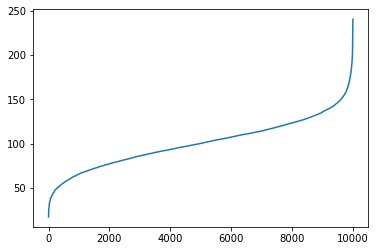

In [7]:
Splot = St
plt.plot(np.sort(Splot))
np.min(Splot), np.max(Splot)

(0.0, 50.0)

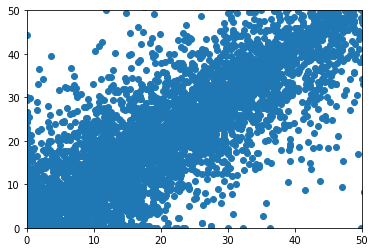

In [8]:
plt.scatter(Ot,OT)
plt.xlim([0,50])
plt.ylim([0,50])

In [9]:
#Srange = np.linspace(20,180,1000)
Srange = np.linspace(min_idx_t,max_idx_t,1000)

In [10]:
# Heston Calculation
y_true = np.zeros_like(Srange)       # true prices from integration
y_delta = np.zeros_like(Srange)      # true delta from integration
y_delta_mv = np.zeros_like(Srange)   # mean variance delta using Heston delta, BS delta and vega
bs_delta = []                        # BS delta
for idx in range(len(Srange)):
    hest_mod_idx = hest.Heston(S=Srange[idx],r = r, q = 0, kappa = kappa, vLong = vLong, sigma= sigma ,v0=v0, rho= rho)
    y_true[idx] = hest_mod_idx.heston_call_piterbarg(K,T-t)
    y_delta[idx] = hest_mod_idx.heston_call_piterbarg_delta(K,T-t)
    bsp, bsd, bsv = PriceEuroVanilla(Srange[idx], K, T-t, r, np.sqrt(v0), option = 'call')
    bs_delta.append(bsd)
    y_delta_mv[idx] = bsd + 0.5 * rho * sigma / np.sqrt(v0) * bsv / Srange[idx]

In [11]:
# fit a Gaussian and calculate the conditional expectation analytically
# for the conditioning using a control variate
# this is the Panda case

ngmm = 3                                # number of mixture distributions
                                  
X_condvar_o = np.vstack((ST,OT,St)).T   # set up the training set

# init a Gaussian Mixture model with ngmm components on the training data
gmm_vo = mixture.GaussianMixture(n_components=ngmm).fit(X_condvar_o)

# calculate the conditional distribution based on mixtures
gmm_cond_v_o = GMM_Conditional(means=gmm_vo.means_,
                           covariances=gmm_vo.covariances_,
                           weights=gmm_vo.weights_,
                           n_components=gmm_vo.n_components,
                           D1=2, D2=1)


In [12]:
# calculate beta (ie. delta) conditionally on CV
def calcdelta(mu, cov, weights):
    covar_cond_w = []
    i = 0
    for w in weights:
        covar_cond_w.append(w * cov[i])
        i = i + 1

    c = np.sum(covar_cond_w, axis = 0)
    
    return c[0,1] / c[0,0]

# calculate the means conditionally on CV
def calcm(mu, cov, weights):
    mu_cond_w = []
    i = 0
    for w in weights:
        mu_cond_w.append(w * mu[i])
        i = i + 1
    
    m = np.sum(mu_cond_w, axis = 0)
    
    return m[0],  m[1]

In [13]:
delta = []
mu = []
#Srange = np.linspace(20,180,1000)
for s in Srange:
    mu_cond, covar_cond, weights_cond = gmm_cond_v_o.par_x1_cond_x2(s)
    delta.append(calcdelta(mu_cond, covar_cond, weights_cond))
    mu.append(calcm(mu_cond, covar_cond, weights_cond))

In [14]:
MU = np.asarray(mu)                                            # plain gmm-dcke estimator
gmm_dcke = MU[:,1] + delta *(Srange - MU[:,0])                  # cv corrected gmm-dcke estimator

In [15]:
# LSM for comparison
d=7                                                            # number of basis functions
poly = PolynomialFeatures(degree=d, include_bias=False)        # basis functions
X_LSM = poly.fit_transform(np.atleast_2d(St).T)
reg = LinearRegression(fit_intercept=True)                     # set up regression
reg.fit(X_LSM, np.atleast_2d(OT).T)                            # fit lsm
y_pred_lsm = reg.predict(poly.fit_transform(np.atleast_2d(Srange).T)).squeeze()            # prediction for price
delta_lsm = polyval(Srange, polyder(np.concatenate((reg.intercept_ , reg.coef_[0]))),)     # prediction for delta

In [16]:
# fitting a GPR to the results obtained by gmm-dcke
delta_gpr = []
mu_gpr = []
Srange_gpr = Srange               #set the range for applying GPR

for s in Srange_gpr:
    # fit to all values on the range
    mu_cond, covar_cond, weights_cond = gmm_cond_v_o.par_x1_cond_x2(s)
    delta_gpr.append(calcdelta(mu_cond, covar_cond, weights_cond))
    mu_gpr.append(calcm(mu_cond, covar_cond, weights_cond))

MU_gpr = np.asarray(mu_gpr)                                                        # estimator
gmm_dcke_gpr = np.maximum(MU_gpr[:,1] + delta_gpr *(Srange_gpr - MU_gpr[:,0]),0.)   # estimator with cv

# GPR for GMM
# Instantiate a Gaussian Process model, with an initial alpha of the full payoff sample std dev
kernel_gmm = ConstantKernel(1.0, (1e-3, 1e1)) * RBF(100, (1e-3, 1e1))
gp_gmm = GaussianProcessRegressor(kernel=kernel_gmm, n_restarts_optimizer=10)

# Fit to data using Maximum Likelihood Estimaton of the parameters
gp_gmm.fit(np.atleast_2d(Srange_gpr).T, np.atleast_2d(gmm_dcke_gpr).T)

# Make the prediction on the meshed x-axis (ask for MSE as well)
gmm_dcke_gpr, gp_sigma_gmm = gp_gmm.predict(np.atleast_2d(Srange).T, return_std=True)

C:\Users\KienitzJoerg\anaconda3\envs\ML_3_6\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\KienitzJoerg\anaconda3\envs\ML_3_6\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


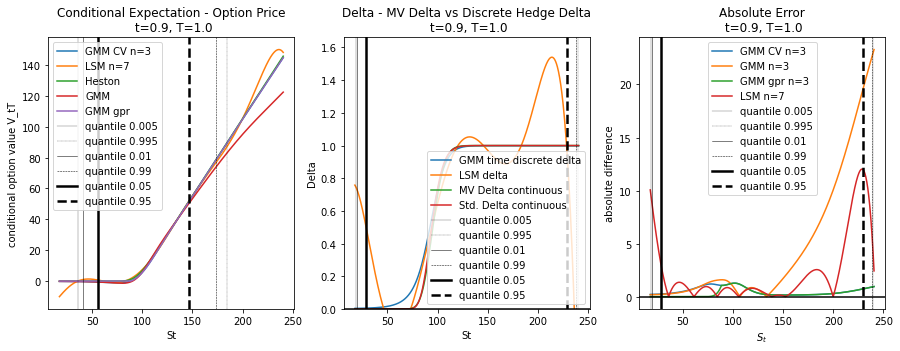

In [17]:
title_str = "gmm-dcke_heston_" + str(time_grid[idx_t]) + "_ngmm_" + str(ngmm) + ".pdf"
quantile_list = [0.005, 0.01, 0.05]


fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,5))
#fig.suptitle('Option Analysis')
ax1.plot(Srange, gmm_dcke, label = "GMM CV n=" + str(ngmm))
ax1.plot(Srange, y_pred_lsm, label = "LSM n=" + str(d))
ax1.plot(Srange, y_true, label = "Heston")
ax1.plot(Srange, MU[:,1], label = "GMM")
ax1.plot(Srange, gmm_dcke_gpr, label = "GMM gpr")
ax1.title.set_text("Conditional Expectation - Option Price\n t=" + str(time_grid[idx_t]) + ", T=" + str(T))
ax1.set(xlabel='x-label', ylabel='y-label')
ax1.set(xlabel='St', ylabel = 'conditional option value V_tT')

for q in quantile_list:
    ax1.axvline(x=np.quantile(St,q), linestyle="-", c = 'black', lw = q*50, label = "quantile " + str(q))
    ax1.axvline(x=np.quantile(St,1-q), linestyle="--", c = 'black', lw = q * 50, label = "quantile " + str(1-q))
ax1.legend()

ax2.title.set_text("Delta - MV Delta vs Discrete Hedge Delta\n t=" + str(time_grid[idx_t]) + ", T=" + str(T))
ax2.plot(Srange, delta, label = "GMM time discrete delta")
ax2.plot(Srange, delta_lsm, label = "LSM delta")
ax2.plot(Srange, y_delta_mv, label = "MV Delta continuous")
ax2.plot(Srange, y_delta, label = "Std. Delta continuous")
ax2.set(xlabel = 'St', ylabel = 'Delta')
for q in quantile_list:
    ax2.axvline(x=np.quantile(Srange,q), linestyle="-", c = 'black', lw = q*50, label = "quantile " + str(q))
    ax2.axvline(x=np.quantile(Srange,1-q), linestyle="--", c = 'black', lw = q * 50, label = "quantile " + str(1-q))
ax2.axhline(y=0, color='k')
ax2.set_ylim(bottom=0)
ax2.legend()

ax3.title.set_text("Absolute Error\n t=" + str(time_grid[idx_t]) + ", T=" + str(T))
ax3.plot(Srange, np.abs(y_true -gmm_dcke), label='GMM CV n=' + str(ngmm))
ax3.plot(Srange, np.abs(y_true - MU[:,1]), label='GMM n=' + str(ngmm))
ax3.plot(Srange, np.abs(y_true - gmm_dcke_gpr[:,0]), label='GMM gpr n=' + str(ngmm))
ax3.plot(Srange, np.abs(y_true - y_pred_lsm), label='LSM n=' + str(d))
ax3.set(xlabel = '$S_t$', ylabel = "absolute difference")
for q in quantile_list:
    ax3.axvline(x=np.quantile(Srange,q), linestyle="-", c = 'black', lw = q*50, label = "quantile " + str(q))
    ax3.axvline(x=np.quantile(Srange,1-q), linestyle="--", c = 'black', lw = q * 50, label = "quantile " + str(1-q))
ax3.axhline(y=0, color='k')
ax3.legend()



#plt.savefig(title_str)
plt.show()



In [18]:
#### Conditional Variance with DCKE/Panda ends